# Task:-> Forecasting_Monthly_Milk_Productions
### Dataset:- monthly_milk_production data from 1962 to 1975
### Model:- ARIMA and SARIMA

In [250]:
import numpy as  np
import pandas as pd

In [251]:
# Load Dataset
df = pd.read_csv("./Data/monthly_milk_production.csv",index_col='Date',parse_dates=True)

In [252]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [253]:
# Null values
df.isnull().count()

Production    168
dtype: int64

In [254]:
# Statics data
df.describe()

,Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


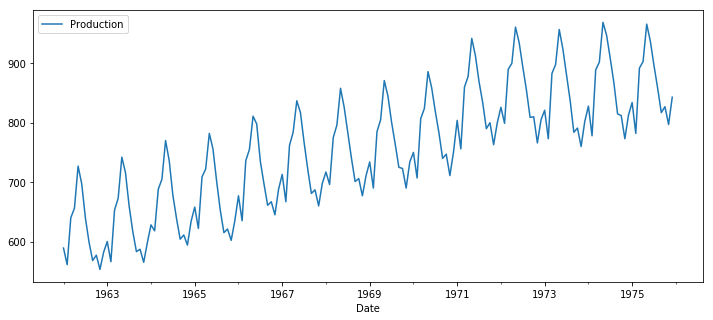

In [255]:
# Data plotting
df.plot(figsize=(12,5));

In [256]:
# setting of frequency
df.index.freq='MS'

In [257]:
df.index

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '1975-03-01', '1975-04-01', '1975-05-01', '1975-06-01',
               '1975-07-01', '1975-08-01', '1975-09-01', '1975-10-01',
               '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='Date', length=168, freq='MS')

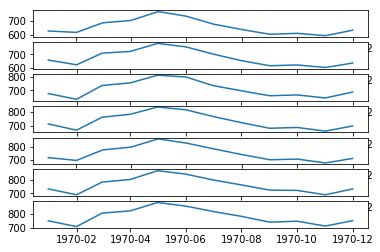

In [258]:
#Yearly plotting of Data

from pandas import Grouper
import matplotlib.pyplot as plt
groups = df['1964':'1970'].groupby(Grouper(freq='A'))
years = pd.DataFrame()
plt.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
    plt.subplot((n_groups*100) + 10 + i)
    i += 1
    plt.plot(group)
plt.show()

# Differencing the data for stationarity

In [259]:
# create a differenced df

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

# Invert Differenced Value

In [260]:
def inverse_difference(history, yhat, interval=0):
    yhat['Production_org']= history['Production'].iloc[0] + yhat['Production_1d'].cumsum()
    return yhat

# ADF Test

In [261]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [262]:
# Lets check the stationarity of series
adf_test(df['Production'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.303812
p-value                   0.627427
# lags used              13.000000
# observations          154.000000
critical value (1%)      -3.473543
critical value (5%)      -2.880498
critical value (10%)     -2.576878
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [432]:
# Let take first difference of the data
df_fod = difference(df['Production'])

In [433]:
# Converting the data into dataframe

idx = pd.date_range('01/02/1962','1975-12-01', freq='MS')
df_forecast = pd.DataFrame(df_fod, index=idx, columns=['Production_1d'])
df_forecast.head()

,Production_1d
1962-02-01,-28
1962-03-01,79
1962-04-01,16
1962-05-01,71
1962-06-01,-30


In [265]:
# res = inverse_difference(df,df_forecast)

In [266]:
# Performing the ADF Test

adf_test(df_forecast['Production_1d'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.054996
p-value                   0.030068
# lags used              14.000000
# observations          152.000000
critical value (1%)      -3.474121
critical value (5%)      -2.880750
critical value (10%)     -2.577013
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


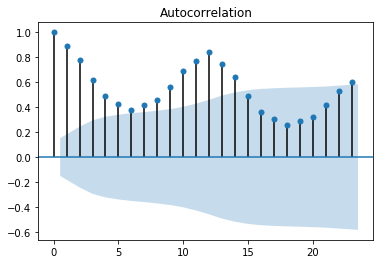

In [297]:
# Loading the specific forecasting tools
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['Production']);

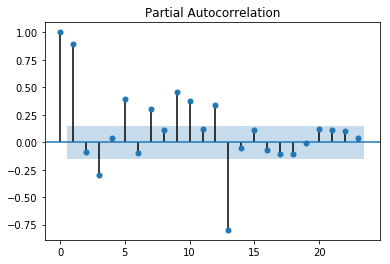

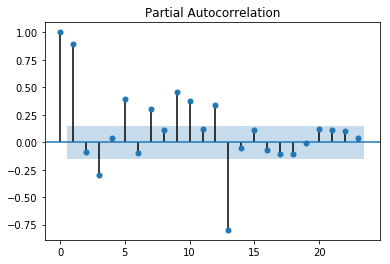

In [296]:
# Partial Autocorrelation plot
plot_pacf(df['Production'])

# Train_Test_Spliting of data for Validation of model

In [269]:
train_size = 12
train, test = df_forecast['Production_1d'][:-train_size], df_forecast['Production_1d'][-train_size:]

# Grid Search ARIMA Parameter

In [161]:
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(train, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=48.617
ARIMA(0, 0, 2) RMSE=46.069
ARIMA(0, 0, 3) RMSE=41.806
ARIMA(0, 0, 4) RMSE=39.583
ARIMA(0, 0, 5) RMSE=37.429
ARIMA(0, 0, 6) RMSE=44.625
ARIMA(0, 1, 1) RMSE=48.447
ARIMA(0, 1, 2) RMSE=48.701
ARIMA(0, 1, 3) RMSE=46.169
ARIMA(0, 1, 4) RMSE=42.664
ARIMA(0, 1, 5) RMSE=38.942
ARIMA(0, 1, 6) RMSE=39.807
ARIMA(0, 2, 1) RMSE=72.404
ARIMA(0, 2, 2) RMSE=48.606
ARIMA(0, 2, 3) RMSE=48.834
ARIMA(0, 2, 4) RMSE=46.589
ARIMA(0, 2, 5) RMSE=52.110
ARIMA(1, 0, 0) RMSE=48.733
ARIMA(1, 0, 1) RMSE=48.909
ARIMA(1, 0, 2) RMSE=45.926
ARIMA(1, 0, 3) RMSE=41.152
ARIMA(1, 0, 4) RMSE=38.355
ARIMA(1, 0, 5) RMSE=35.497
ARIMA(1, 0, 6) RMSE=35.206
ARIMA(1, 1, 0) RMSE=54.372
ARIMA(1, 1, 1) RMSE=53.708
ARIMA(1, 2, 0) RMSE=80.677
ARIMA(2, 0, 0) RMSE=47.265
ARIMA(2, 0, 1) RMSE=47.358
ARIMA(2, 0, 2) RMSE=45.898
ARIMA(2, 0, 3) RMSE=40.717
ARIMA(2, 0, 4) RMSE=38.824
ARIMA(2, 0, 5) RMSE=38.998
ARIMA(2, 0, 6) RMSE=37.680
ARIMA(2, 1, 0) RMSE=53.574
ARIMA(2, 1, 1) RMSE=47.387
ARIMA(2, 2, 0) RMSE=63.180
A

# Auto Arima Model For Order Evaluation

In [270]:
# pmdarima 
from pmdarima import auto_arima
auto_arima(df['Production'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  168
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -806.604
Date:                Thu, 20 Feb 2020   AIC                           1627.208
Time:                        13:36:24   BIC                           1649.034
Sample:                             0   HQIC                          1636.066
                                - 168                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5630      0.233      2.412      0.016       0.106       1.021
ar.L1          1.2289      0.103     11.972      0.000       1.028       1.430
ar.L2         -0.1609      0.172     -0.938      0.348      -0.497       0.175
ar.L3         -0.4504      0.098     -4.608      0.000      -0.642      -0.259
ma.L1         -1.9125      0.184    -10.413      0.000      -2.273      -1.553
ma.L2          0.9964      0.191      5.223      0.000       0.622       1.370
sigma2       861.1362    191.188      4.504      0.000     486.414    1235.859
===================================================================================
Ljung-Box (Q):                      510.52   Jarque-Bera (JB):                28.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.89
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARIMA MODEL

In [331]:
model = ARIMA(train, order=(6,0,5))
model_fit =  model.fit(trend='nc', disp=0)

# Predicting the value

In [311]:
start=len(train)
end=len(train)+len(test)-1
predictions = model_fit.predict(start=start, end=end, dynamic=False, typ='levels')
# test_fore = model_fit.predict(test)

In [312]:
predictions

1975-01-01    15.080778
1975-02-01     3.410053
1975-03-01    72.944035
1975-04-01    -2.266805
1975-05-01    53.191754
1975-06-01   -23.347826
1975-07-01   -25.188947
1975-08-01   -15.638229
1975-09-01   -73.421409
1975-10-01     7.303473
1975-11-01   -50.845784
1975-12-01    22.001337
Freq: MS, dtype: float64

In [313]:
test

1975-01-01     21
1975-02-01    -52
1975-03-01    110
1975-04-01     11
1975-05-01     63
1975-06-01    -29
1975-07-01    -41
1975-08-01    -38
1975-09-01    -41
1975-10-01     10
1975-11-01    -30
1975-12-01     46
Freq: MS, Name: Production_1d, dtype: int64

# Plotting The Graph between test value and predicted value

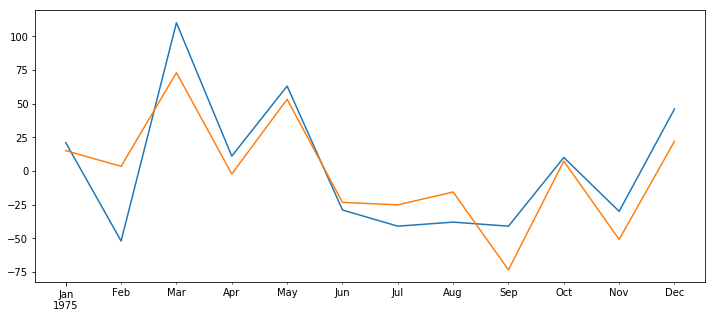

In [314]:
# Graph plotting
test.plot(figsize=(12,6));
predictions.plot(figsize=(12,5));

# Evaluation of Model

In [315]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test, predictions)
print(f'ARIMA(6,0,5) RMSE Error: {error:11.10}')

ARIMA(6,0,5) RMSE Error: 25.16868465


In [316]:
df[-13:].mean()

Production    858.846154
dtype: float64

In [317]:
idx = pd.date_range('01/01/1975', periods=12, freq='MS')
df_forecast = pd.DataFrame(predictions, index=idx, columns=['Production_1d'])
df_forecast

,Production_1d
1975-01-01,15.080778
1975-02-01,3.410053
1975-03-01,72.944035
1975-04-01,-2.266805
1975-05-01,53.191754
1975-06-01,-23.347826
1975-07-01,-25.188947
1975-08-01,-15.638229
1975-09-01,-73.421409
1975-10-01,7.303473


# Inverse the difference for original Prediction

In [318]:
def inverse_difference(history, yhat, interval=-13):
    yhat['Production_org']= history['Production'].iloc[interval] + yhat['Production_1d'].cumsum()
    return yhat


In [319]:
pred_true = inverse_difference(df,df_forecast)

In [320]:
pred_true

,Production_1d,Production_org
1975-01-01,15.080778,828.080778
1975-02-01,3.410053,831.490831
1975-03-01,72.944035,904.434866
1975-04-01,-2.266805,902.168061
1975-05-01,53.191754,955.359815
1975-06-01,-23.347826,932.011989
1975-07-01,-25.188947,906.823041
1975-08-01,-15.638229,891.184812
1975-09-01,-73.421409,817.763403
1975-10-01,7.303473,825.066877


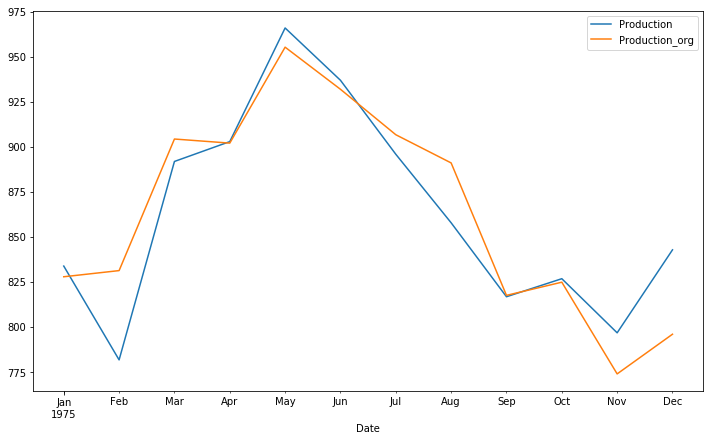

In [321]:
# Graph between predicted and original value
df[-12:].plot(figsize=(12,7));
pred_true['Production_org'].plot(legend=True);

# Full Data Training Of the Model

In [327]:
df_forecast.head()

,Production_1d,Production_org
1975-01-01,15.080778,828.080778
1975-02-01,3.410053,831.490831
1975-03-01,72.944035,904.434866
1975-04-01,-2.266805,902.168061
1975-05-01,53.191754,955.359815


In [343]:
data = df_forecast["Production_1d"]
model = ARIMA(data, order=(6,0,5))
model_fit =  model.fit(trend='nc', disp=0)

In [357]:
start=len(df_forecast)
end=len(df_forecast)+12
final_predictions = model_fit.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA (6,0,5)')

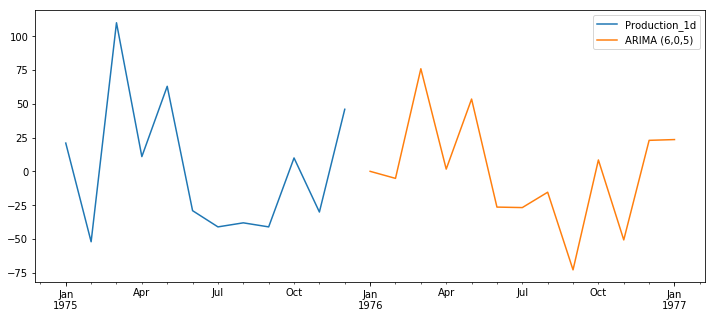

In [358]:
df_forecast['1975-01-01':].plot(figsize=(12,5));
final_predictions.plot(figsize=(12,5),legend=True);

# SARIMA Model

In [361]:
auto_arima(df_forecast['Production_1d'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  167
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -530.104
Date:                              Thu, 20 Feb 2020   AIC                           1068.208
Time:                                      16:50:17   BIC                           1080.381
Sample:                                           0   HQIC                          1073.152
                                              - 167                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0211      0.287     -0.073      0.942      -0.584       0.542
ar.L1         -0.2254      0.079     -2.838      0.005      -0.381      -0.070
ma.S.L12      -0.6193      0.071     -8.693      0.000      -0.759      -0.480
sigma2        52.6876      5.099     10.332      0.000      42.693      62.682
===================================================================================
Ljung-Box (Q):                       22.08   Jarque-Bera (JB):                35.12
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.74
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [362]:
# SARIMAX(2, 0, 0)x(0, 1, [1], 12)

In [367]:
# Train and Test Split

train_s = df_forecast[:-12]
test_s  = df_forecast[-12:]

In [369]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_s ,order=(1,0,0),seasonal_order=(0, 1, 1, 12))

In [370]:
# Fitting the model
model_fits = model.fit()

In [371]:
model_fits.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                        Production_1d   No. Observations:                  155
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -491.269
Date:                              Thu, 20 Feb 2020   AIC                            988.537
Time:                                      16:56:52   BIC                            997.426
Sample:                                  02-01-1962   HQIC                           992.149
                                       - 12-01-1974                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2512      0.081     -3.093      0.002      -0.410      -0.092
ma.S.L12      -0.6090      0.078     -7.858      0.000      -0.761      -0.457
sigma2        54.2524      5.265     10.303      0.000      43.932      64.573
===================================================================================
Ljung-Box (Q):                       24.00   Jarque-Bera (JB):                38.10
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.79
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [373]:
# Predicting the value
start = len(train)
end   = len(train)+len(test)-1
predictions = model_fits.predict(start,end,typ ='level').rename('SARIMA (1,0,0) Predictions')

In [374]:
predictions

1975-01-01     25.322615
1975-02-01    -44.498382
1975-03-01    104.882544
1975-04-01     14.273136
1975-05-01     63.277272
1975-06-01    -26.401414
1975-07-01    -41.486187
1975-08-01    -40.595873
1975-09-01    -49.050368
1975-10-01      2.122915
1975-11-01    -36.594182
1975-12-01     40.010729
Freq: MS, Name: SARIMA (1,0,0) Predictions, dtype: float64

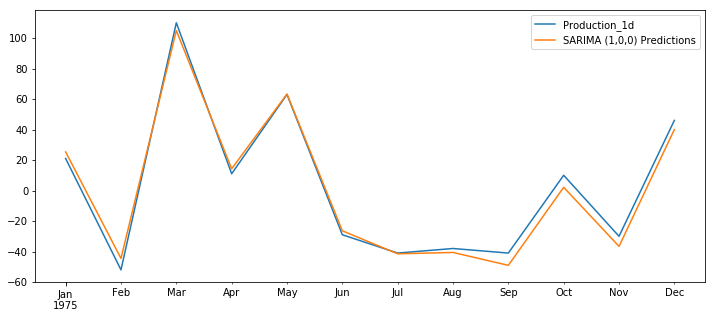

In [376]:
# Plot between test and predicted value
test.plot(figsize=(12,5),legend=True)
predictions.plot(figsize=(12,5),legend=True)

It's Seem Nice fiting of graph.

# Evaluating the model

In [402]:
# RootMeanSquareError
from statsmodels.tools.eval_measures import rmse
error = rmse(test_s['Production_1d'], predictions)
print(f'ARIMA(6,0,5) RMSE Error: {error:11.10}')

ARIMA(6,0,5) RMSE Error: 5.258936889


In [403]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df_forecast ,order=(1,0,0),seasonal_order=(0, 1, 1, 12))

In [404]:
result_final = model.fit()

In [435]:
# Prediction 
start = len(df_forecast)
end   = len(df_forecast)+11
final_forecast = result_final.predict(start,end,typ ='level')

In [436]:
final_forecast

1976-01-01     22.349579
1976-02-01    -46.962221
1976-03-01    106.632007
1976-04-01     13.077018
1976-05-01     63.141984
1976-06-01    -27.408297
1976-07-01    -41.352506
1976-08-01    -39.588514
1976-09-01    -45.894729
1976-10-01      5.171799
1976-11-01    -34.035630
1976-12-01     42.278132
Freq: MS, dtype: float64

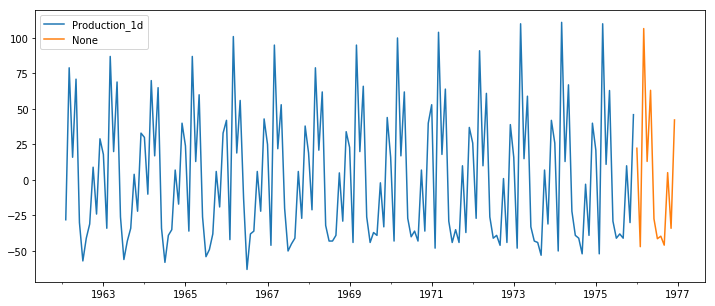

In [438]:
df_forecast.plot(figsize=(12,5),legend=True)
final_forecast.plot(figsize=(12,5),legend=True);

# Inverting The data

In [441]:
idx = pd.date_range('01/01/1976', periods=12, freq='MS')
df_fore = pd.DataFrame(final_forecast, index=idx, columns=['final_pred'])
df_fore

,final_pred
1976-01-01,22.349579
1976-02-01,-46.962221
1976-03-01,106.632007
1976-04-01,13.077018
1976-05-01,63.141984
1976-06-01,-27.408297
1976-07-01,-41.352506
1976-08-01,-39.588514
1976-09-01,-45.894729
1976-10-01,5.171799


In [454]:
df['Production'][-13:]

Date
1974-12-01    813
1975-01-01    834
1975-02-01    782
1975-03-01    892
1975-04-01    903
1975-05-01    966
1975-06-01    937
1975-07-01    896
1975-08-01    858
1975-09-01    817
1975-10-01    827
1975-11-01    797
1975-12-01    843
Freq: MS, Name: Production, dtype: int64

In [467]:
def inverse_difference_final(history, yhat, interval=-1):
    yhat['Production_forcast']= history['Production'].iloc[interval] + yhat['final_pred'].cumsum()
    return yhat

In [468]:
final_inv = inverse_difference_final(df,df_fore)

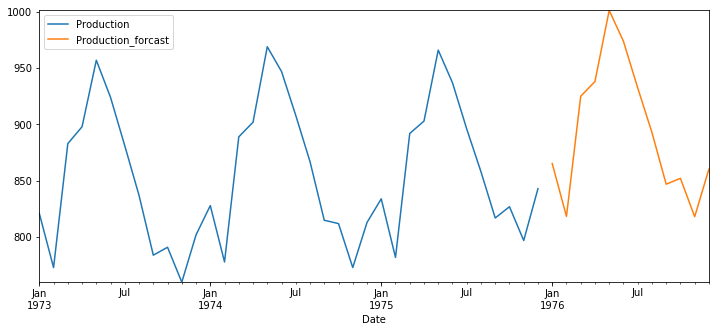

In [471]:
ax = df['Production']['1973-01-01':].plot(figsize=(12,5),legend=True)
final_inv['Production_forcast'].plot(figsize=(12,5),legend=True);
ax.autoscale(axis='both', tight=True)

# Thanks!